In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0., alpha_2=0., T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x/1000, y/1000, z
    

In [3]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)


In [4]:
u = U[:,:,0]
v = V[:,:,0]

def moca1(n_ic, n_jc, r=14):

    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    return x0, y0, l, xx, yy, u1, v1, a, b, c

n_ic = 50
n_jc = 60

n_ic2 = 50
n_jc2 = 54

n_ic3 = 50
n_jc3 = 66

x0, y0, l, xx, yy, u1, v1, a, b, c = moca1(n_ic, n_jc)

x02, y02, l2, xx2, yy2, u2, v2, a2, b2, c2  = moca1(n_ic2, n_jc2) # closest
x03, y03, l3, xx3, yy3, u3, v3, a3, b3, c3  = moca1(n_ic3, n_jc3) # furthest

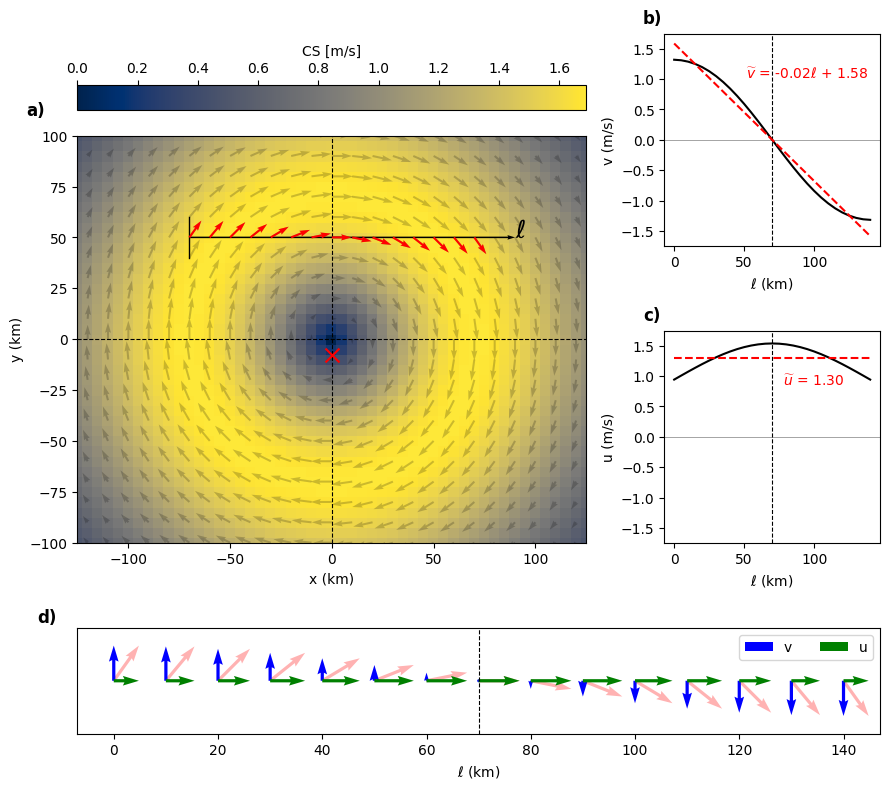

xc=0.0, yc=[-7.61412232], a=[1.30266544], b=1.5827123135842465, c=-0.022610175908346377


In [5]:

import matplotlib.gridspec as gridspec

# GridSpec for custom layout
fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 0.5])  # Add extra row with smaller height

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:2, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)  # Horizontal grid line at y=0
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)  # Vertical grid line at x=0

spacing = 2
scale = 40
width = 0.004
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=100, label='MOCA Result', zorder=4)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

# Other transects
alpha = .7
# # closest
# ax_main.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
# ax_main.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
# # furthest
# ax_main.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='c', zorder=3, alpha=alpha)
# ax_main.scatter(x03, y03, color='c', marker='x', s=70, zorder=3, alpha=alpha)

# l axis
ax_main.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
ax_main.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
ax_main.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

coeffs_v = np.polyfit(l, v1, 1)
fit_line_v = np.poly1d(coeffs_v)
ax2.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)

# ax2.quiver(l[::spacing], [0] * len(l[::spacing]), [0] * len(v1[::spacing]), v1[::spacing],
#                  width=width, color=colors[0], alpha=1, label='v', scale=scale, scale_units='xy')

ax2.plot(l, v1, color='k')
ax2.plot(l, fit_line_v(l), linestyle="--", color='r')
ax2.set_xlabel(r'$\ell$ (km)')
ax2.set_ylabel('v (m/s)')
ax2.text(0.38, 0.85, fr"$\widetilde{{v}}$ = {coeffs_v[0]:.2f}$\ell$ + {coeffs_v[1]:.2f}", transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2.text(-0.1, 1.05, 'b)', transform=ax2.transAxes, fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)

coeffs_u = np.polyfit(l, u1, 0)
fit_line_u = np.poly1d(coeffs_u)
ax3.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3.plot(l, u1, color='k')
ax3.plot(l, fit_line_u(l), linestyle="--", color='r')
ax3.set_xlabel(r'$\ell$ (km)')
ax3.set_ylabel('u (m/s)')
ax3.text(0.55, 0.80, fr"$\widetilde{{u}}$ = {coeffs_u[0]:.2f}", transform=ax3.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3.text(-0.1, 1.05, 'c)', transform=ax3.transAxes, fontsize=12, fontweight='bold')
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

# Add 1x3 plot at the bottom
ax_bottom = fig.add_subplot(gs[2, :])
alpha = 0.3
width = 0.004
scale = 30
colors = ['b', 'g']

ax_bottom.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)

ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], v1[::spacing],
                 width=width, alpha=alpha, color='r', scale=scale)
ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), [0] * len(v1[::spacing]), v1[::spacing],
                 width=width, color=colors[0], alpha=1, label='v', scale=scale)
ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], [0] * len(u1[::spacing]),
                 width=width, color=colors[1], alpha=1, label='u', scale=scale)


ax_bottom.set_xlabel(r'$\ell$ (km)')
ax_bottom.yaxis.set_ticks([])
ax_bottom.yaxis.set_tick_params(length=0)
ax_bottom.set_yticklabels([])
ax_bottom.legend(loc='upper right', ncol=3)
ax_bottom.text(-0.05, 1.05, 'd)', transform=ax_bottom.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
print(f'xc={x0}, yc={y0}, a={a}, b={b}, c={c}')

In [6]:
def moca1(n_ic, n_jc, r=14):

    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)[0]
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    w = 2*c

    return x0, y0, l, xx, yy, u1, v1, a, b, c, w

n_ic = 50
n_jc = 60

n_ic2 = 50
n_jc2 = 54
r2 = 8

n_ic3 = 50
n_jc3 = 66
r3 = 20

x0, y0, l, xx, yy, u1, v1, a, b, c, w = moca1(n_ic, n_jc)

x02, y02, l2, xx2, yy2, u2, v2, a2, b2, c2, w2  = moca1(n_ic2, n_jc2) # closest 
x03, y03, l3, xx3, yy3, u3, v3, a3, b3, c3, w3  = moca1(n_ic3, n_jc3) # furthest

x02_r, y02_r, l2_r, xx2_r, yy2_r, u2_r, v2_r, a2_r, b2_r, c2_r, w2_r  = moca1(n_ic, n_jc, r2) # shortest
x03_r, y03_r, l3_r, xx3_r, yy3_r, u3_r, v3_r, a3_r, b3_r, c3_r, w3_r  = moca1(n_ic, n_jc, r3) # longest

dx = x[1]-x[0]

print(28*dx, 2*r2*dx, 2*r3*dx)

140.0 80.0 200.0


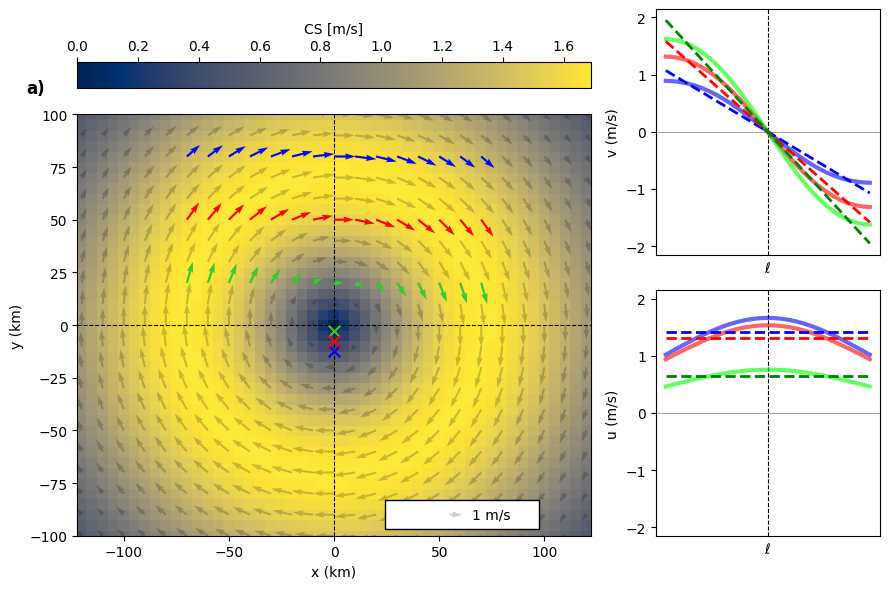

xc=0.0, yc=-7.614122320746979, a=1.3026654404770746, b=1.5827123135842465, c=-0.022610175908346377


In [7]:
from matplotlib.patches import Rectangle

# GridSpec for custom layout (Removed third row)
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 40
width = 0.004
alpha = 1
quiv = ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
ax_main.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main.scatter(x03, y03, color='b', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

magnitude = 1
x_pos, y_pos = 0.75, 0.05  
box_width = 0.3  # Adjust width as needed
box_height = 0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
ax_main.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
             label=f'{magnitude} m/s', labelpos='E')

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2, 1))
ax2.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2.plot(d1, v3, color=(0, 0, 1, 0.6), linewidth=3)
ax2.plot(d2, v1, color=(1, 0, 0, 0.6), linewidth=3)
ax2.plot(d3, v2, color=(0, 1, 0, 0.6), linewidth=3)
ax2.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2.set_ylabel('v (m/s)')
ax2.set_xlabel(r'$\ell$')
ax2.set_xticks([])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2, 1))
ax3.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3.plot(d1, u3, color=(0, 0, 1, 0.6), linewidth=3)
ax3.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
ax3.plot(d3, u2, color=(0, 1, 0, 0.6), linewidth=3)
ax3.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax3.set_ylabel('u (m/s)')
ax3.set_xlabel(r'$\ell$')
ax3.set_xticks([])

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)
ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()
print(f'xc={x0}, yc={y0}, a={a}, b={b}, c={c}')



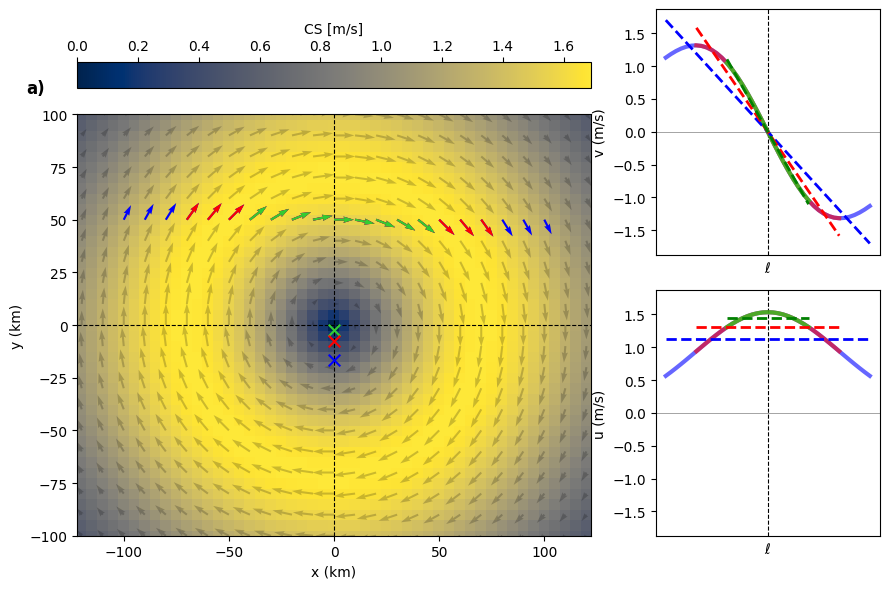

xc=0.0, yc=-7.614122320746979, a=1.3026654404770746, b=1.5827123135842465, c=-0.022610175908346377


In [8]:
# GridSpec for custom layout (Removed third row)
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 40
width = 0.004
alpha = 1
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx3_r[::spacing], yy3_r[::spacing], u3_r[::spacing], v3_r[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main.scatter(x03_r, y03_r, color='b', marker='x', s=70, zorder=3, alpha=alpha)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main.quiver(xx2_r[::spacing], yy2_r[::spacing], u2_r[::spacing], v2_r[::spacing], scale=scale, width=width, color='limegreen', zorder=5, alpha=alpha)
ax_main.scatter(x02_r, y02_r, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)

plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2_r, 1))
ax2.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2.plot(d1, v3_r, color=(0, 0, 1, 0.6), linewidth=3)
ax2.plot(d2, v1, color=(1, 0, 0, 0.6), linewidth=3)
ax2.plot(d3, v2_r, color=(0, 1, 0, 0.6), linewidth=3)
ax2.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2.set_ylabel('v (m/s)')
ax2.set_xlabel(r'$\ell$')
ax2.set_xticks([])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2_r, 1))
ax3.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3.plot(d1, u3_r, color=(0, 0, 1, 0.6), linewidth=3)
ax3.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
ax3.plot(d3, u2_r, color=(0, 1, 0, 0.6), linewidth=3)
ax3.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3

ax3.set_ylabel('u (m/s)')
ax3.set_xlabel(r'$\ell$')
ax3.set_xticks([])

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()
print(f'xc={x0}, yc={y0}, a={a}, b={b}, c={c}')

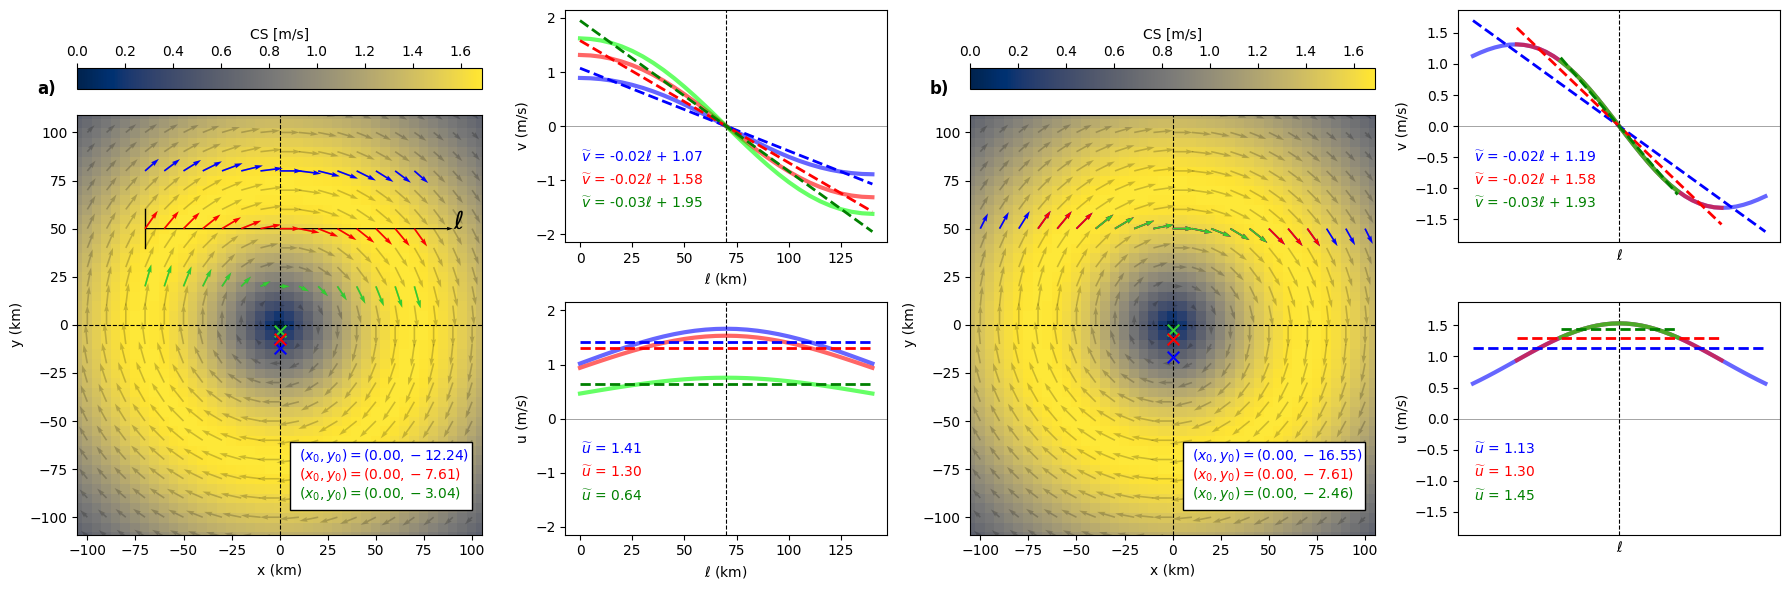

In [9]:
# Combined Plot: Left and Right Side by Side

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

# l axis
ax_main_left.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
ax_main_left.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
ax_main_left.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)

ax_main_left.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_left.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_left.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main_left.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
ax_main_left.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_left.scatter(x03, y03, color='b', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')

x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_left.add_patch(rect)

ax_main_left.text(10 , -70, fr'$(x_0,y_0)=({x03:.2f},{y03:.2f})$', color='b')
ax_main_left.text(10 , -80, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color='r')
ax_main_left.text(10 , -90, fr'$(x_0,y_0)=({x02:.2f},{y02:.2f})$', color='g')

ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2, 1))
ax2_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.plot(d1, v3, color=(0, 0, 1, 0.6), linewidth=3)
ax2_left.plot(d2, v1, color=(1, 0, 0, 0.6), linewidth=3)
ax2_left.plot(d3, v2, color=(0, 1, 0, 0.6), linewidth=3)
ax2_left.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2_left.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2_left.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2_left.text(0.05, 0.4, fr"$\widetilde{{v}}$ = {fit1[1]:.2f}$\ell$ + {fit1[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax2_left.text(0.05, 0.3, fr"$\widetilde{{v}}$ = {fit2[1]:.2f}$\ell$ + {fit2[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2_left.text(0.05, 0.2, fr"$\widetilde{{v}}$ = {fit3[1]:.2f}$\ell$ + {fit3[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax2_left.set_ylabel('v (m/s)')
ax2_left.set_xlabel(r'$\ell$ (km)')
# ax2_left.set_xticks([])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2, 1))
ax3_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.plot(d1, u3, color=(0, 0, 1, 0.6), linewidth=3)
ax3_left.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
ax3_left.plot(d3, u2, color=(0, 1, 0, 0.6), linewidth=3)
ax3_left.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3_left.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3_left.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax3_left.text(0.05, 0.4, fr"$\widetilde{{u}}$ = {fit1[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax3_left.text(0.05, 0.3, fr"$\widetilde{{u}}$ = {fit2[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3_left.text(0.05, 0.2, fr"$\widetilde{{u}}$ = {fit3[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax3_left.set_ylabel('u (m/s)')
ax3_left.set_xlabel(r'$\ell$ (km)')
# ax3_left.set_xticks([])

ymin1, ymax1 = ax2_left.get_ylim()
ymin2, ymax2 = ax3_left.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2_left.set_ylim(ymin, ymax)
ax3_left.set_ylim(ymin, ymax)

# RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

quiv = ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main_right.quiver(xx3_r[::spacing], yy3_r[::spacing], u3_r[::spacing], v3_r[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_right.scatter(x03_r, y03_r, color='b', marker='x', s=70, zorder=3, alpha=alpha)
ax_main_right.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_right.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_right.quiver(xx2_r[::spacing], yy2_r[::spacing], u2_r[::spacing], v2_r[::spacing], scale=scale, width=width, color='limegreen', zorder=5, alpha=alpha)
ax_main_right.scatter(x02_r, y02_r, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')

rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_right.add_patch(rect)

ax_main_right.text(10 , -70, fr'$(x_0,y_0)=({x03_r:.2f},{y03_r:.2f})$', color='b')
ax_main_right.text(10 , -80, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color='r')
ax_main_right.text(10 , -90, fr'$(x_0,y_0)=({x02_r:.2f},{y02_r:.2f})$', color='g')

ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'b)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2_r, 1))
ax2_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.plot(d1, v3_r, color=(0, 0, 1, 0.6), linewidth=3)
ax2_right.plot(d2, v1, color=(1, 0, 0, 0.6), linewidth=3)
ax2_right.plot(d3, v2_r, color=(0, 1, 0, 0.6), linewidth=3)
ax2_right.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2_right.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2_right.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2_right.text(0.05, 0.4, fr"$\widetilde{{v}}$ = {fit1[1]:.2f}$\ell$ + {fit1[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax2_right.text(0.05, 0.3, fr"$\widetilde{{v}}$ = {fit2[1]:.2f}$\ell$ + {fit2[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2_right.text(0.05, 0.2, fr"$\widetilde{{v}}$ = {fit3[1]:.2f}$\ell$ + {fit3[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax2_right.set_ylabel('v (m/s)')
ax2_right.set_xlabel(r'$\ell$')
ax2_right.set_xticks([])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2_r, 1))
ax3_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.plot(d1, u3_r, color=(0, 0, 1, 0.6), linewidth=3)
ax3_right.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
ax3_right.plot(d3, u2_r, color=(0, 1, 0, 0.6), linewidth=3)
ax3_right.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3_right.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3_right.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3

ax3_right.text(0.05, 0.4, fr"$\widetilde{{u}}$ = {fit1[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax3_right.text(0.05, 0.3, fr"$\widetilde{{u}}$ = {fit2[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3_right.text(0.05, 0.2, fr"$\widetilde{{u}}$ = {fit3[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='g')

ax3_right.set_ylabel('u (m/s)')
ax3_right.set_xlabel(r'$\ell$')
ax3_right.set_xticks([])

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2_right.set_ylim(ymin, ymax)
ax3_right.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

          y      l           R         w
0       5.0   10.0    0.004172 -0.078343
1       5.0   20.0    0.017502 -0.077875
2       5.0   30.0    0.037582 -0.077180
3       5.0   40.0    0.064517 -0.076265
4       5.0   50.0    0.098443 -0.075139
...     ...    ...         ...       ...
1595  200.0  360.0  281.869980 -0.000290
1596  200.0  370.0  302.650147 -0.000271
1597  200.0  380.0  324.392156 -0.000253
1598  200.0  390.0  347.096357 -0.000237
1599  200.0  400.0  370.759801 -0.000222

[1600 rows x 4 columns]


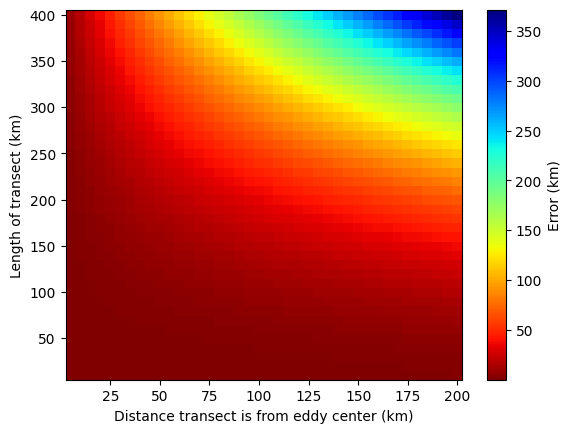

In [10]:
df = pd.DataFrame(columns=['y', 'l', 'R', 'w'])
nic = u.shape[0]//2
dx = x[1] - x[0]
for njc in range(51, 91):
    for ri in range(1, 41):
        x0_test, y0_test, _, _, _, _, _, _, _, _, w = moca1(nic, njc, ri)
        R = np.hypot(x0_test, y0_test)
        df.loc[len(df)] = {'y': y[njc], 'l': 2*dx*ri, 'R': R, 'w': w}
print(df)

Y, L = np.meshgrid(df['y'].unique(), df['l'].unique())
R = df.pivot(index='l', columns='y', values='R').values

plt.pcolor(Y, L, R, cmap='jet_r', shading='auto')
plt.colorbar(label='Error (km)')
# plt.contour(Y, L, R, levels=300, colors='w', linewidths=0.8)  # Add contour lines
plt.xlabel('Distance transect is from eddy center (km)')
plt.ylabel(r'Length of transect (km)')
plt.show()


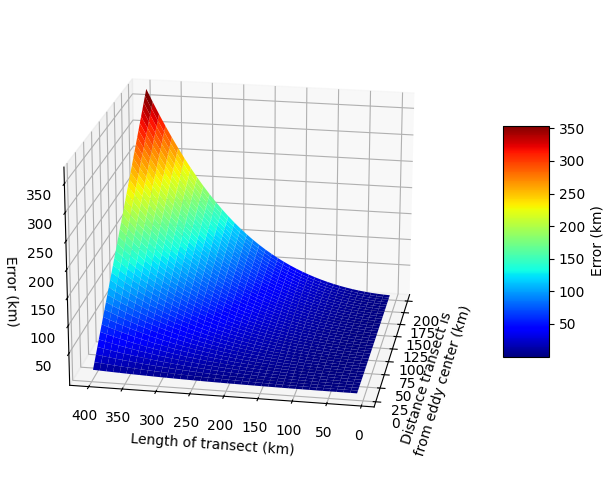

In [11]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Y, L, R, cmap='jet', edgecolor='none', linewidth=0.3)

ax.view_init(elev=20, azim=190)  

ax.set_xlabel('Distance transect is\n from eddy center (km)')
ax.set_ylabel('Length of transect (km)')
ax.set_zlabel('Error (km)')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Error (km)')

plt.show()


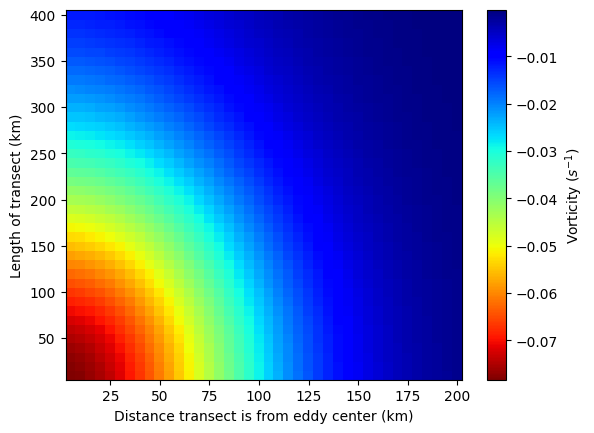

In [12]:
Y, L = np.meshgrid(df['y'].unique(), df['l'].unique())
W = df.pivot(index='l', columns='y', values='w').values

plt.pcolor(Y, L, W, cmap='jet_r', shading='auto')
plt.colorbar(label=r'Vorticity ($s^{-1}$)')
# plt.contour(Y, L, W, levels=300, colors='w', linewidths=0.8)  # Add contour lines
plt.xlabel('Distance transect is from eddy center (km)')
plt.ylabel(r'Length of transect (km)')
plt.show()

Text(0, 0.5, 'Error')

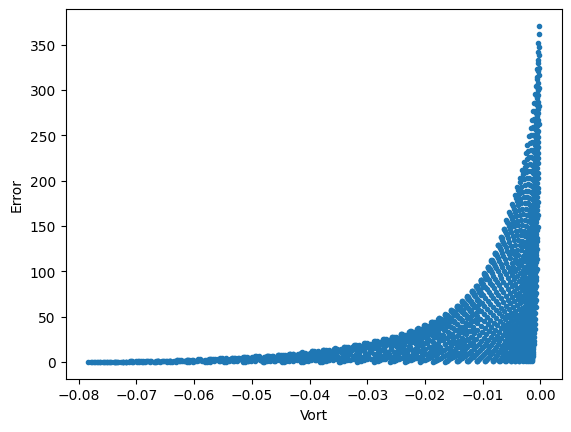

In [13]:
plt.scatter(df['w'], df['R'], marker='.')
plt.xlabel('Vort')
plt.ylabel('Error')


## Improved version

In [14]:
def moca1_mod(n_ic, n_jc, r=14):

    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    
    coeffs = np.polyfit(l, v1, 3)
    p = np.poly1d(coeffs)
    roots = np.roots(p)
    real_roots = roots[np.isreal(roots) & (roots >= min(l)) & (roots <= max(l))].real
    dp = np.polyder(p)
    R = np.abs(real_roots-l[len(l)//2])
    root = real_roots[R==np.min(R)]
    
    slope = dp(root)
    intercept = p(root) - slope * root  
    c, b = slope, intercept

    coeffs = np.polyfit(l, u1, 3)
    p = np.poly1d(coeffs)
    a = p(root)
    
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    w = 2*c

    return x0[0], y0[0], l, xx, yy, u1, v1, a, b, c, w

n_ic = 50
n_jc = 60

n_ic2 = 50
n_jc2 = 54
r2 = 8

n_ic3 = 50
n_jc3 = 66
r3 = 20

x0_m, y0_m, l_m, xx_m, yy_m, u1_m, v1_m, a_m, b_m, c_m, w_m = moca1_mod(n_ic, n_jc)

x02_m, y02_m, l2_m, xx2_m, yy2_m, u2_m, v2_m, a2_m, b2_m, c2_m, w2_m  = moca1_mod(n_ic2, n_jc2) # closest 
x03_m, y03_m, l3_m, xx3_m, yy3_m, u3_m, v3_m, a3_m, b3_m, c3_m, w3_m  = moca1_mod(n_ic3, n_jc3) # furthest

x02_r_m, y02_r_m, l2_r_m, xx2_r_m, yy2_r_m, u2_r_m, v2_r_m, a2_r_m, b2_r_m, c2_r_m, w2_r_m  = moca1_mod(n_ic, n_jc, r2) # shortest
x03_r_m, y03_r_m, l3_r_m, xx3_r_m, yy3_r_m, u3_r_m, v3_r_m, a3_r_m, b3_r_m, c3_r_m, w3_r_m  = moca1_mod(n_ic, n_jc, r3) # longest

dx = x[1]-x[0]

print(28*dx, 2*r2*dx, 2*r3*dx)

140.0 80.0 200.0


In [15]:
def cubic_tangent_plot(x, y):
    coeffs = np.polyfit(x, y, 3)
    p = np.poly1d(coeffs)
    roots = np.roots(p)
    real_roots = roots[np.isreal(roots) & (roots >= min(x)) & (roots <= max(x))].real
    
    dp = np.polyder(p)
    R = np.abs(real_roots-x[len(x)//2])
    root = real_roots[R==np.min(R)]
    slope = dp(root)
    intercept = p(root) - slope * root  
    fit = np.poly1d((slope[0], intercept[0]))
    return fit, root #l_0

def cubic_crit_tangent_plot(x, y, l0):

    coeffs = np.polyfit(x, y, 3)
    p = np.poly1d(coeffs)
    fit = np.poly1d(p(l0))
    return fit



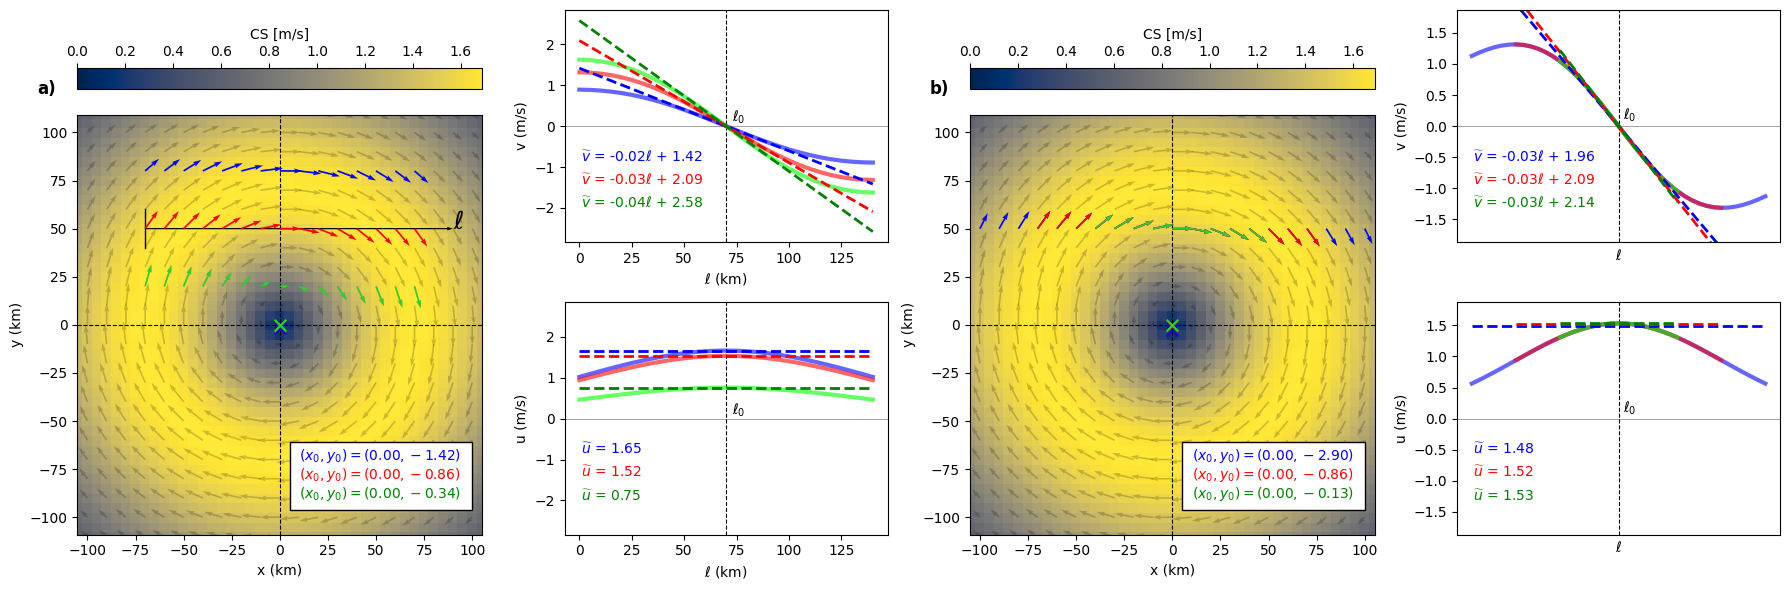

In [16]:
# Combined Plot: Left and Right Side by Side

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

# l axis
ax_main_left.quiver(xx_m[0], yy_m[0], xx_m[-1] - xx_m[0] + 20, yy_m[-1] - yy_m[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
ax_main_left.plot([xx_m[0], xx_m[0]], [yy_m[0] - 10, yy_m[0] + 10], color='k', linewidth=1)
ax_main_left.text(xx_m[-1] + 20, yy_m[0], r'$\ell$', fontsize=18)

ax_main_left.quiver(xx_m[::spacing], yy_m[::spacing], u1_m[::spacing], v1_m[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_left.scatter(x0_m, y0_m, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_left.quiver(xx2_m[::spacing], yy2_m[::spacing], u2_m[::spacing], v2_m[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main_left.scatter(x02_m, y02_m, color='limegreen', marker='x', s=70, zorder=4, alpha=alpha)
ax_main_left.quiver(xx3_m[::spacing], yy3_m[::spacing], u3_m[::spacing], v3_m[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_left.scatter(x03_m, y03_m, color='b', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')

x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_left.add_patch(rect)

ax_main_left.text(10 , -70, fr'$(x_0,y_0)=({np.abs(x03_m):.2f},{y03_m:.2f})$', color='b')
ax_main_left.text(10 , -80, fr'$(x_0,y_0)=({np.abs(x0_m):.2f},{y0_m:.2f})$', color='r')
ax_main_left.text(10 , -90, fr'$(x_0,y_0)=({np.abs(x02_m):.2f},{y02_m:.2f})$', color='g')

ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3_m + xx3_m[0] - xx_m[0], l_m, l2_m + xx2_m[0] - xx_m[0]
fit1, l03 = cubic_tangent_plot(d1, v3_m)
fit2, l01 = cubic_tangent_plot(d2, v1_m)
fit3, l02 = cubic_tangent_plot(d3, v2_m)

ax2_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.plot(d1, v3_m, color=(0, 0, 1, 0.6), linewidth=3)
ax2_left.plot(d2, v1_m, color=(1, 0, 0, 0.6), linewidth=3)
ax2_left.plot(d3, v2_m, color=(0, 1, 0, 0.6), linewidth=3)
ax2_left.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2_left.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2_left.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2_left.text(0.05, 0.4, fr"$\widetilde{{v}}$ = {fit1[1]:.2f}$\ell$ + {fit1[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax2_left.text(0.05, 0.3, fr"$\widetilde{{v}}$ = {fit2[1]:.2f}$\ell$ + {fit2[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2_left.text(0.05, 0.2, fr"$\widetilde{{v}}$ = {fit3[1]:.2f}$\ell$ + {fit3[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax2_left.text(73, 0.1, r'$\ell_0$', color='k')
ax2_left.set_ylabel('v (m/s)')
ax2_left.set_xlabel(r'$\ell$ (km)')
# ax2_left.set_xticks([])

d1, d2, d3 = l3_m + xx3_m[0] - xx_m[0], l_m, l2_m + xx2_m[0] - xx_m[0]
fit1 = cubic_crit_tangent_plot(d1, u3_m, l03)
fit2 = cubic_crit_tangent_plot(d2, u1_m, l01)
fit3 = cubic_crit_tangent_plot(d3, u2_m, l02)
ax3_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.plot(d1, u3, color=(0, 0, 1, 0.6), linewidth=3)
ax3_left.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
ax3_left.plot(d3, u2, color=(0, 1, 0, 0.6), linewidth=3)
ax3_left.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3_left.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3_left.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax3_left.text(0.05, 0.4, fr"$\widetilde{{u}}$ = {fit1[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax3_left.text(0.05, 0.3, fr"$\widetilde{{u}}$ = {fit2[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3_left.text(0.05, 0.2, fr"$\widetilde{{u}}$ = {fit3[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax3_left.text(73, 0.1, r'$\ell_0$', color='k')
ax3_left.set_ylabel('u (m/s)')
ax3_left.set_xlabel(r'$\ell$ (km)')
# ax3_left.set_xticks([])

ymin1, ymax1 = ax2_left.get_ylim()
ymin2, ymax2 = ax3_left.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2_left.set_ylim(ymin, ymax)
ax3_left.set_ylim(ymin, ymax)

# RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

quiv = ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main_right.quiver(xx3_r_m[::spacing], yy3_r_m[::spacing], u3_r_m[::spacing], v3_r_m[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_right.scatter(x03_r_m, y03_r_m, color='b', marker='x', s=70, zorder=3, alpha=alpha)
ax_main_right.quiver(xx_m[::spacing], yy_m[::spacing], u1_m[::spacing], v1_m[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_right.scatter(x0_m, y0_m, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_right.quiver(xx2_r_m[::spacing], yy2_r_m[::spacing], u2_r_m[::spacing], v2_r_m[::spacing], scale=scale, width=width, color='limegreen', zorder=5, alpha=alpha)
ax_main_right.scatter(x02_r_m, y02_r_m, color='limegreen', marker='x', s=70, zorder=4, alpha=alpha)
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')

rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_right.add_patch(rect)

ax_main_right.text(10 , -70, fr'$(x_0,y_0)=({np.abs(x03_r_m):.2f},{y03_r_m:.2f})$', color='b')
ax_main_right.text(10 , -80, fr'$(x_0,y_0)=({np.abs(x0_m):.2f},{y0_m:.2f})$', color='r')
ax_main_right.text(10 , -90, fr'$(x_0,y_0)=({np.abs(x02_r_m):.2f},{y02_r_m:.2f})$', color='g')

ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'b)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

d1, d2, d3 = l3_r_m + xx3_r_m[0] - xx_m[0], l_m, l2_r_m + xx2_r_m[0] - xx_m[0]
fit1, l03 = cubic_tangent_plot(d1, v3_r_m)
fit2, l01 = cubic_tangent_plot(d2, v1_m)
fit3, l02 = cubic_tangent_plot(d3, v2_r_m)
ax2_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.plot(d1, v3_r_m, color=(0, 0, 1, 0.6), linewidth=3)
ax2_right.plot(d2, v1_m, color=(1, 0, 0, 0.6), linewidth=3)
ax2_right.plot(d3, v2_r_m, color=(0, 1, 0, 0.6), linewidth=3)
ax2_right.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2_right.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2_right.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2_right.text(0.05, 0.4, fr"$\widetilde{{v}}$ = {fit1[1]:.2f}$\ell$ + {fit1[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax2_right.text(0.05, 0.3, fr"$\widetilde{{v}}$ = {fit2[1]:.2f}$\ell$ + {fit2[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2_right.text(0.05, 0.2, fr"$\widetilde{{v}}$ = {fit3[1]:.2f}$\ell$ + {fit3[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax2_right.text(73, 0.1, r'$\ell_0$', color='k')
ax2_right.set_ylabel('v (m/s)')
ax2_right.set_xlabel(r'$\ell$')
ax2_right.set_xticks([])

d1, d2, d3 = l3_r_m + xx3_r_m[0] - xx_m[0], l_m, l2_r_m + xx2_r_m[0] - xx_m[0]
fit1 = cubic_crit_tangent_plot(d1, u3_r_m, l03)
fit2 = cubic_crit_tangent_plot(d2, u1_m, l01)
fit3 = cubic_crit_tangent_plot(d3, u2_r_m, l02)
ax3_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.plot(d1, u3_r_m, color=(0, 0, 1, 0.6), linewidth=3)
ax3_right.plot(d2, u1_m, color=(1, 0, 0, 0.6), linewidth=3)
ax3_right.plot(d3, u2_r_m, color=(0, 1, 0, 0.6), linewidth=3)
ax3_right.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3_right.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3_right.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3

ax3_right.text(0.05, 0.4, fr"$\widetilde{{u}}$ = {fit1[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax3_right.text(0.05, 0.3, fr"$\widetilde{{u}}$ = {fit2[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3_right.text(0.05, 0.2, fr"$\widetilde{{u}}$ = {fit3[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax3_right.text(73, 0.1, r'$\ell_0$', color='k')
ax3_right.set_ylabel('u (m/s)')
ax3_right.set_xlabel(r'$\ell$')
ax3_right.set_xticks([])

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2_right.set_ylim(ymin, ymax)
ax3_right.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## ROMS Application

In [17]:
import pickle
import netCDF4 as nc

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [18]:
def moca1_roms(n_ic, n_jc, r=14):

    u1 = u_roms[n_ic-r:n_ic+r+1, n_jc]
    v1 = v_roms[n_ic-r:n_ic+r+1, n_jc]

    xx = x_roms[n_ic-r:n_ic+r+1]
    yy = [y_roms[n_jc]] * len(xx)
    l = xx - xx[0]
    
    coeffs = np.polyfit(l, v1, 3)
    p = np.poly1d(coeffs)
    roots = np.roots(p)
    real_roots = roots[np.isreal(roots) & (roots >= min(l)) & (roots <= max(l))].real
    dp = np.polyder(p)
    R = np.abs(real_roots-l[len(l)//2])
    root = real_roots[R==np.min(R)]
    
    slope = dp(root)
    intercept = p(root) - slope * root  
    c, b = slope, intercept

    coeffs = np.polyfit(l, u1, 3)
    p = np.poly1d(coeffs)
    a = p(root)
    
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    w = 2*c

    return x0[0], y0[0], l, xx, yy, u1, v1, a, b, c, w

In [27]:
eddy = the_frontier_eddies[0]
t = 0
U_roms, V_roms, x_roms, y_roms = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']
X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1] - x_roms[0]
var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1

depth_lvl = 0
u_roms, v_roms = U_roms[:,:,depth_lvl], V_roms[:,:,depth_lvl]

nic = 50
njc = 55
x0_roms, y0_roms, l_roms, xx_roms, yy_roms, u1_roms, v1_roms, a_roms, b_roms, c_roms, w_roms = moca1_roms(nic, njc, 15)


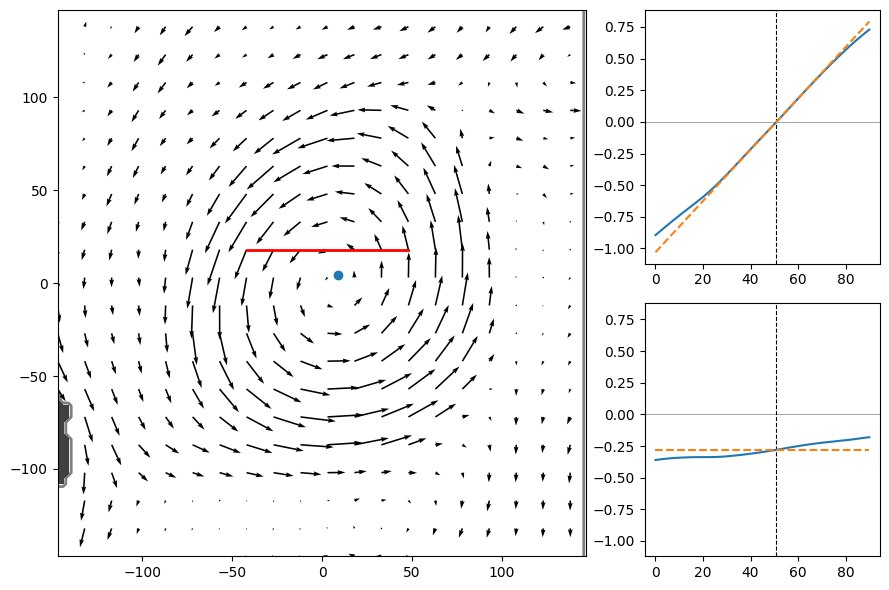

In [28]:
# GridSpec for custom layout (Removed third row)
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:, :2])

if np.any(np.isnan(u_roms)):
    nan_mask = np.isnan(u_roms)
    mask = np.where(~np.isnan(u_roms), np.nan, 0)
    ax_main.contourf(X_roms/1000, Y_roms/1000, mask.T, cmap='gray', zorder=-1)
    ax_main.contour(X_roms/1000, Y_roms/1000, nan_mask.T, colors='k', linewidths=2, alpha=.5)

spacing = 5
ax_main.quiver(x_roms[::spacing]/1000, y_roms[::spacing]/1000, u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)
ax_main.plot(np.array(xx_roms)/1000, np.array(yy_roms)/1000, color='r', linewidth=2)
ax_main.scatter(x0_roms/1000, y0_roms/1000)

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

ax2.plot(l_roms/1000, v1_roms)
fit, l0_roms = cubic_tangent_plot(l_roms, v1_roms)
ax2.plot(l_roms/1000, fit(l_roms), linestyle='--')
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2.axvline(l0_roms/1000, color='black', linewidth=0.8, linestyle='--', zorder=0)

ax3.plot(l_roms/1000, u1_roms)
fit = cubic_crit_tangent_plot(l_roms, u1_roms, l0_roms)
ax3.plot(l_roms/1000, fit(l_roms), linestyle='--')
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3.axvline(l0_roms/1000, color='black', linewidth=0.8, linestyle='--', zorder=0)

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)
ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [21]:
# from matplotlib.patches import Rectangle

# # GridSpec for custom layout (Removed third row)
# fig = plt.figure(figsize=(9, 6))
# gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# # Main 2x3 plot
# ax_main = fig.add_subplot(gs[:, :2])
# pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
# ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
# ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

# spacing = 2
# scale = 40
# width = 0.004
# alpha = 1
# quiv = ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
# ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
# ax_main.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
# ax_main.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
# ax_main.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
# ax_main.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
# ax_main.scatter(x03, y03, color='b', marker='x', s=70, zorder=3, alpha=alpha)
# plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

# magnitude = 1
# x_pos, y_pos = 0.75, 0.05  
# box_width = 0.3  # Adjust width as needed
# box_height = 0.07  # Adjust height as needed
# rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
#                        box_width, box_height, transform=ax_main.transAxes,
#                        facecolor='white', edgecolor='black')
# ax_main.add_patch(rect)
# ax_main.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
#              label=f'{magnitude} m/s', labelpos='E')

# ax_main.axis('equal')
# ax_main.set_xlim(-100, 100)
# ax_main.set_ylim(-100, 100)
# ax_main.set_xlabel('x (km)')
# ax_main.set_ylabel('y (km)')
# ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# # Subplot columns (2x1 on the right)
# ax2 = fig.add_subplot(gs[0, 2])
# ax3 = fig.add_subplot(gs[1, 2])

# d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
# fit1 = np.poly1d(np.polyfit(d1, v3, 1))
# fit2 = np.poly1d(np.polyfit(d2, v1, 1))
# fit3 = np.poly1d(np.polyfit(d3, v2, 1))
# ax2.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
# ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
# ax2.plot(d1, v3, color=(0, 0, 1, 0.6), linewidth=3)
# ax2.plot(d2, v1, color=(1, 0, 0, 0.6), linewidth=3)
# ax2.plot(d3, v2, color=(0, 1, 0, 0.6), linewidth=3)
# ax2.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
# ax2.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
# ax2.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
# ax2.set_ylabel('v (m/s)')
# ax2.set_xlabel(r'$\ell$')
# ax2.set_xticks([])

# d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
# fit1 = np.poly1d(np.polyfit(d1, u3, 1))
# fit2 = np.poly1d(np.polyfit(d2, u1, 1))
# fit3 = np.poly1d(np.polyfit(d3, u2, 1))
# ax3.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
# ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
# ax3.plot(d1, u3, color=(0, 0, 1, 0.6), linewidth=3)
# ax3.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
# ax3.plot(d3, u2, color=(0, 1, 0, 0.6), linewidth=3)
# ax3.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
# ax3.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
# ax3.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
# ax3.set_ylabel('u (m/s)')
# ax3.set_xlabel(r'$\ell$')
# ax3.set_xticks([])

# ymin1, ymax1 = ax2.get_ylim()
# ymin2, ymax2 = ax3.get_ylim()
# ymin = min(ymin1, ymin2)
# ymax = max(ymax1, ymax2)
# ax2.set_ylim(ymin, ymax)
# ax3.set_ylim(ymin, ymax)

# plt.tight_layout()
# plt.show()
# print(f'xc={x0}, yc={y0}, a={a}, b={b}, c={c}')









